# Cluster-based permutation tests with EEG data

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import os

from mne.channels import find_ch_adjacency, make_1020_channel_selections
import mne

from niseq import sequential_cluster_test_indep

np.random.seed(0)

We'll use the same data as an [MNE tutorial](https://mne.tools/dev/auto_tutorials/stats-sensor-space/20_erp_stats.html) uses for visualizing significance thresholds, so you can check that tutorial out if you want to compare e.g. the differences in how the input data `X` is formatted.

In [2]:
# load the data
data_dir = mne.datasets.kiloword.data_path()
fpath = os.path.join(data_dir, 'kword_metadata-epo.fif')
epochs = mne.read_epochs(fpath)
epochs = epochs.decimate(4, verbose = 'error')

Reading /home/johnv/mne_data/MNE-kiloword-data/kword_metadata-epo.fif ...
Isotrak not found
    Found the data of interest:
        t =    -100.00 ...     920.00 ms
        0 CTF compensation matrices available
Adding metadata with 8 columns
960 matching events found
No baseline correction applied
0 projection items activated


In [3]:
# extract data from MNE object as array
X = epochs.get_data()
X.shape

(960, 29, 64)

In [4]:
# construct array of condition labels based on word length
name = "NumberOfLetters"
median_value = str(epochs.metadata[name].median())
conds = np.zeros(X.shape[0])
conds[epochs[name + " > " + median_value].selection] = 1
conds.shape

(960,)

First we compute the adjacency matrix between neighboring sensors so that our clustering routine knows what channels are next to each other.

In [5]:
neighb, _ = find_ch_adjacency(epochs.info, "eeg")

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 29


In [6]:
X.shape

(960, 29, 64)

Since MNE's clustering routine requires that observations (e.g. trials or subjects) be the first dimension, time be the second dimension, and channels (or whatever the adjacency matrix describes) is the last dimension, we have to flip the axes of our EEG data `X`.

In [7]:
X = np.transpose(X, (0, 2, 1))  # transpose for clustering
X.shape # observations x time x channels 

(960, 64, 29)

In [8]:
n_max = X.shape[0]
n_looks = 4
look_times = [i*n_max//n_looks for i in range(1, n_looks + 1)]

looks, ps, adj_alphas, spending = sequential_cluster_test_indep(
    X, conds,
    look_times, n_max,
    n_jobs = -1
)

/home/johnv/anaconda3/lib/python3.8/site-packages/niseq/_clustering.py:50: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  warn('Ignoring argument "tail", performing 1-tailed F-test')
/home/johnv/anaconda3/lib/python3.8/site-packages/niseq/_clustering.py:50: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  warn('Ignoring argument "tail", performing 1-tailed F-test')
/home/johnv/anaconda3/lib/python3.8/site-packages/niseq/_clustering.py:50: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  warn('Ignoring argument "tail", performing 1-tailed F-test')
/home/johnv/anaconda3/lib/python3.8/site-packages/niseq/_clustering.py:50: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  warn('Ignoring argument "tail", performing 1-tailed F-test')
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 162 ta

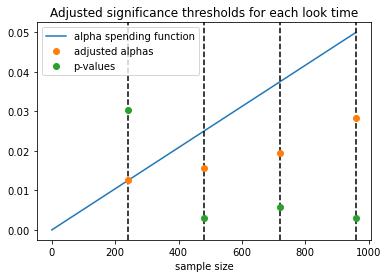

failed to reject null at n = 240
rejected null at n = 480
rejected null at n = 720
rejected null at n = 960


In [9]:
plt.plot([0] + look_times, [0] + spending.tolist(), label = 'alpha spending function')
for lt in look_times:
    plt.axvline(lt, linestyle = '--', color = 'black')
plt.plot(look_times, adj_alphas, 'o', label = 'adjusted alphas')
plt.plot(look_times, ps, 'o', label = 'p-values')
plt.xlabel('sample size')
plt.title('Adjusted significance thresholds for each look time')
plt.legend()
plt.show()

reject = ps < adj_alphas
for n, r in zip(look_times, reject):
    if r:
        print('rejected null at n = %d'%n)
    else:
        print('failed to reject null at n = %d'%n)

The $p$-value drops below the adjusted $\alpha$ on the second look, so we would've stopped data collection at $n = 480$ trials using this sequential design instead of collecting the full $n_\max = 960$.

Let's visualize the clusters on the basis of which the null was rejected at the second look.

In [10]:
t_stop = 1
n_stop = look_times[t_stop]
adj_alpha = adj_alphas[t_stop]
obs, clusters, cluster_pvs, _ = looks[n_stop]
sig_clusters = [
    clusters[i] for i in range(len(clusters)) 
    if cluster_pvs[i] < adj_alpha
]

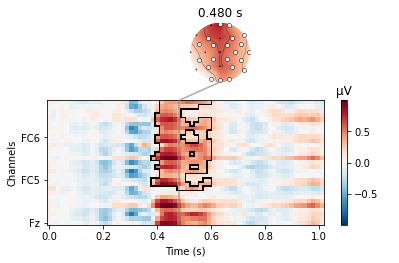

In [11]:
from mne.viz.utils import _prepare_joint_axes, _connection_line

_X = epochs.get_data()
effect_map = _X[conds == 1].mean(0) - _X[conds == 0].mean(0)

effect = mne.EvokedArray(effect_map, epochs.info)
effect.nave = None

# prepare axes
fig, main_ax, map_axs, cbar_ax = _prepare_joint_axes(len(sig_clusters), figsize = None)

# plot effect map
cluster_mask = np.any(np.stack(sig_clusters, axis = 0), axis = 0)
fig = effect.plot_image(
    mask = cluster_mask.T, 
    mask_alpha = 1., # don't fade out
    mask_cmap = 'RdBu_r', # same as unmasked
    show_names = True,
    colorbar = True,
    axes = main_ax,
    show = False
)
main_ax.set_title(' ')
vmin, vmax = main_ax.images[0].get_clim() # remember color limits

# plot topomaps for midpoints of clusters
idx_clusts = [np.median(np.where(clust.sum(1) > 0)) for clust in sig_clusters]
idx_clusts = [int(idx) for idx in idx_clusts]
t_clusts = [effect.times[idx] for idx in idx_clusts]
t_clusts = sorted(t_clusts)
effect.plot_topomap(times = t_clusts, axes = map_axs, 
                    mask = cluster_mask.T, 
                    mask_params = {'markersize': 8},
                    vlim = (vmin, vmax),
                    colorbar = False,
                    show = False
                   )

# hide superfluous axes
cbar_ax.grid(False) 
cbar_ax.axis('off')

# draw connecting lines
lines = [_connection_line(timepoint, fig, main_ax, map_ax_)
             for timepoint, map_ax_ in zip(t_clusts, map_axs)]
for line in lines:
    fig.lines.append(line)
for timepoint in t_clusts:
    main_ax.axvline(timepoint, color = 'grey', linestyle = '-',
                      linewidth = 1.5, alpha = .66)
    
    
# show final plot
plt.show()


Note that the correspinding [MNE tutorial](https://mne.tools/dev/auto_tutorials/stats-sensor-space/20_erp_stats.html) for a fixed-sample design also highlights an earlier, negatively valued cluster. A sequential design might terminate data collection after a strong cluster results in the null hypothesis being rejected, leaving weaker clusters unnoticed. Of course, just because you _can_ stop when the null hypothesis is first rejected, that doesn't mean you _have to_; you can keep collecting data if you want to get a better estimate of effect size/location. (That said, [one should use caution](https://doi.org/10.1111/psyp.13335) when using cluster-based tests to localize effects in the first place.)

## Threshold-Free Cluster Enhancement

Just like in the MNE API, you can use TFCE instead of a thresholded cluster-based permutation test by specifying a dictionary as your `threshold` argument. 

In [12]:
threshold_tfce = dict(start = 0, step = 0.2)
looks, ps, adj_alphas, spending = sequential_cluster_test_indep(
    X, conds,
    look_times, n_max,
    threshold = threshold_tfce,
    n_jobs = -1
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  66 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 156 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 444 tasks      | elapsed:   29.6s
[Parallel(n_jobs=-1)]: Done 642 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 1024 out of 1024 | elapsed:  1.1min finished


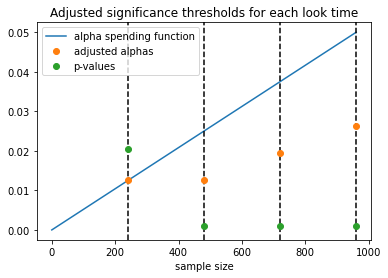

failed to reject null at n = 240
rejected null at n = 480
rejected null at n = 720
rejected null at n = 960


In [13]:
plt.plot([0] + look_times, [0] + spending.tolist(), label = 'alpha spending function')
for lt in look_times:
    plt.axvline(lt, linestyle = '--', color = 'black')
plt.plot(look_times, adj_alphas, 'o', label = 'adjusted alphas')
plt.plot(look_times, ps, 'o', label = 'p-values')
plt.xlabel('sample size')
plt.title('Adjusted significance thresholds for each look time')
plt.legend()
plt.show()

reject = ps < adj_alphas
for n, r in zip(look_times, reject):
    if r:
        print('rejected null at n = %d'%n)
    else:
        print('failed to reject null at n = %d'%n)